## Feature Selection Methods

Given that the T2D dataset has more features than samples (2750 features vs ~2100 samples), there aren't enough degrees of freedom to reliably train a machine learning model. Most of the classifiers trained on the existing dataset max out at ~0.67 ROC AUC. Possible feature selection approaches are detailed below. This notebook explores the efficacy of various feature selection techniques and stores new training datasets to test model performance on under src/data/T2D_data/.

In [164]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import chi2, mutual_info_classif
from itertools import compress
import matplotlib.pyplot as plt
import jupyterthemes
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='oceans16')

In [165]:
t2d_train_df = pd.read_csv("../data/T2D_data/T2D_train.csv").drop(t2d_train_df.columns[0], axis=1)
t2d_test_df = pd.read_csv("../data/T2D_data/T2D_test.csv").drop(t2d_test_df.columns[0], axis=1)
t2d_train_df.head()

,type,MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed,MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed,GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed,K562_ChIP-seq_CTCF_ENCFF002CEL.bed,K562_ChIP-seq_POLR2A_ENCFF002CET.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed,keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed,keratinocyte_ChIP-seq_POLR2A_ENCFF002CFC.bed,...,Hepatocyte_PPARA_GW7647_24hr.bed,liver_USF1_ctrl_peaks.narrowPeak,liver_USF1_ASH_peaks.narrowPeak,islet_pooled_H3K4me1_final.bed,islet_CTCF_intersectall.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount,weight
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,1.5
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,1.5
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.5
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,36,1.5
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1.5


In [166]:
# Create training and test splits, dropping labels and sample weights from training set
X_train = t2d_train_df.drop(['type', 'weight'], axis=1)
y_train = t2d_train_df.loc[:, 'type']

X_test = t2d_test_df.drop(['type'], axis=1)
y_test = t2d_test_df.loc[:, 'type']

In [ ]:
# In case we want to run some tests on the entire combined dataset
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [167]:
X_train.head()

,MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed,MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed,GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed,K562_ChIP-seq_CTCF_ENCFF002CEL.bed,K562_ChIP-seq_POLR2A_ENCFF002CET.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed,keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed,keratinocyte_ChIP-seq_POLR2A_ENCFF002CFC.bed,H1-hESC_ChIP-seq_H3K27me3_ENCFF001SUY.bed,...,Hepatocyte_PPARA_GW7647_2hr.bed,Hepatocyte_PPARA_GW7647_24hr.bed,liver_USF1_ctrl_peaks.narrowPeak,liver_USF1_ASH_peaks.narrowPeak,islet_pooled_H3K4me1_final.bed,islet_CTCF_intersectall.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,36
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [205]:
# Pass coefficents and feature names to see most important features
def feat_importance(scores, names, n=10):
    imp = scores
    imp,names = zip(*sorted(zip(imp,names)))
    print("Features:")
    print(names[-20:])
    fig = plt.figure(num=None, figsize=(10, 7), dpi=80)
    plt.barh(range(len(names[-n:])), imp[-n:], align='center')
    plt.yticks(range(len(names[-n:])), names[-n:])
    plt.title("Most Important Features \n")
    plt.xlabel("score")
    plt.ylabel("features")
    plt.show()

### Variance Threshold

VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.

In a dataset with boolean features we can remove all features that are either one or zero in more than a certain % of the samples. We can further prune the feature set by taking only the top n features in terms of displaying the most variance.

Since boolean variables are Bernoulli random variables, their variance is given by p(1-p). 

In [178]:
selector = VarianceThreshold(threshold=.70 * (1 - .70))
selector.fit_transform(X_train, y_train)

array([[ 1,  0,  1, ...,  0,  0, 11],
       [ 0,  0,  0, ...,  0,  0,  5],
       [ 1,  0,  1, ...,  0,  0,  1],
       ...,
       [ 1,  0,  1, ...,  1,  1,  8],
       [ 0,  0,  1, ...,  1,  1,  5],
       [ 0,  0,  0, ...,  0,  0, 31]])

In [179]:
print(selector.variances_)

[9.74178646e-02 1.30270453e-02 1.10037231e-01 ... 2.12541965e-01
 1.53023991e-01 2.58739434e+03]


In [180]:
print ("Samples remaining in the featureset: {}".format(len(selector.variances_)))

Samples remaining in the featureset: 2748


Here we set n to some number, representing the number of features that we want to keep. We obtain the indices of elements with the highest variance and create a new dataframe for training containing only those features.

In [181]:
# Select the top n features, where features are ranked based on how much variance they display
n = 1000
top_idx = np.argsort(selector.variances_)[-n:]
vt_features = [selector.variances_[i] for i in top_idx]
vt_traindf = X_train.iloc[:, top_idx]
vt_testdf = X_test.iloc[:, top_idx]

In [182]:
vt_traindf.head()

,E099-H3K4me3.gappedPeak,wgEncodeAwgDnaseUwdukeTh1UniPk.narrowPeak,E035-H3K4me3.gappedPeak,E087-H3K36me3.gappedPeak,E032-H3K27ac.gappedPeak,E100-H3K9me3.gappedPeak,Loucy_ChIP-seq_H3K27ac_ENCFF024YNQ.bed,E053-H3K36me3.gappedPeak,E098-H3K4me3.gappedPeak,E030-H3K36me3.gappedPeak,...,E003-H3K4me1.gappedPeak,E030-H3K27me3.gappedPeak,E044-H3K27me3.gappedPeak,E127-H3K4me1.gappedPeak,E021-H3K4me1.gappedPeak,E002-H3K36me3.gappedPeak,E114-H3K4me1.gappedPeak,E095-H3K4me1.gappedPeak,E084-H3K9me3.gappedPeak,snpcount
0,0,0,0,1,1,0,0,1,0,1,...,0,0,1,1,0,1,0,0,0,11
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,5
2,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
3,0,0,1,1,1,0,1,1,0,1,...,0,0,0,1,1,1,1,1,1,36
4,0,1,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,2


In [183]:
# Write the created dataset to a file so we can test model performance later
vt_traindf.to_csv("../data/T2D_data/FeatureSelected/var_threshold/X_train")
y_train.to_csv("../data/T2D_data/FeatureSelected/var_threshold/y_train")
vt_testdf.to_csv("../data/T2D_data/FeatureSelected/var_threshold/X_test")
y_test.to_csv("../data/T2D_data/FeatureSelected/var_threshold/y_test")

### Univariate Feature Selection

The sklearn GenericUnivariateSelect allows to perform univariate feature selection with a configurable strategy. This allows us to select the best univariate selection strategy with a hyper-parameter search estimator, similar to grid search. Here I've compared the association of the features to a target variable using a chi square test and sklearn's mutual info classificaion test. 

First we set the scoring parameter of the class to the chi2 test, selecting the n best performing features. 

In [184]:
# Return n best features based on the test
n = 20
chi_gus = GenericUnivariateSelect(chi2, mode='k_best', param=n)
chi_gus.fit(X_train, y_train)

GenericUnivariateSelect(mode='k_best', param=20,
            score_func=<function chi2 at 0x1a19febae8>)

In [185]:
# Save features using the boolean mask 
chi_idx = chi_gus.get_support()
chi_features = list(compress(X_train.columns, chi_idx)) 
chi_pvalues = list(compress(chi_gus.pvalues_, chi_idx))

Features:
('snpcount', 'PDX1', 'FOXA2', 'PancIslt-EnhA', 'NKX2.2', 'Islets.stretchEnhancers.bed', 'E087-H3K27ac.gappedPeak', 'E008-H3K79me2.gappedPeak', 'E118-H3K79me2.gappedPeak', 'GSE64233_p65_V_final.bed', 'E122-H4K20me1.gappedPeak', 'MAFB', 'islet_pooled_H3K27ac.bed', 'PANC.ISLT-EnhA', 'PE_Active_Enhancers_hg19.bed', 'GSM1208788_batch2_chrom1_LoVo_RARG_PassedQC_peaks_hg19.bed', 'GSM1208731_batch2_chrom1_LoVo_E2F8_PassedQC_peaks_hg19.bed', 'E004-H3K79me2.gappedPeak', 'E004-H3K79me1.gappedPeak', 'PANC.ISLT-EnhWk')


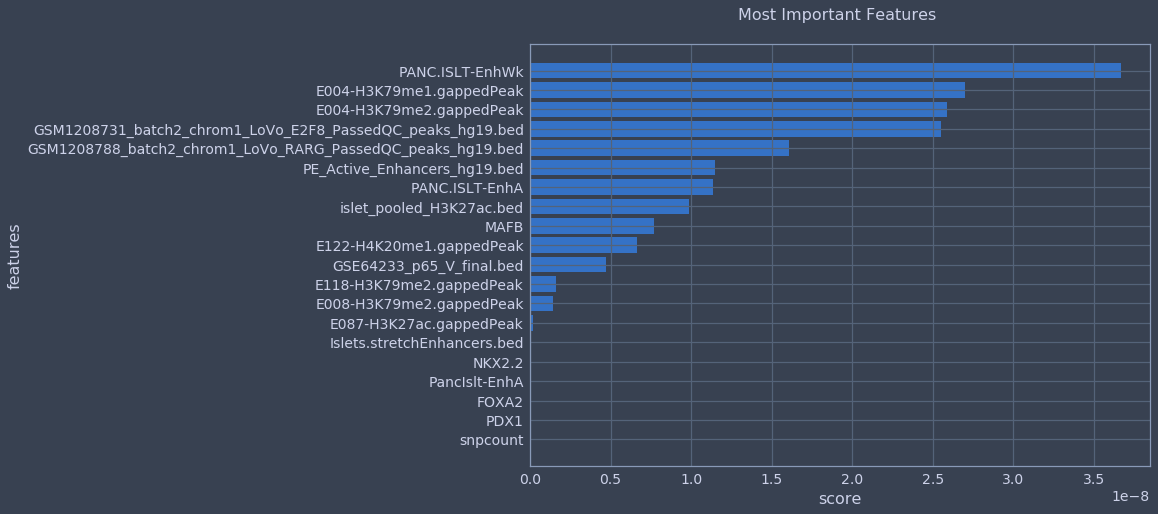

In [186]:
# Visualize p values for each feature from test
feat_importance(chi_pvalues, chi_features, n=len(chi_features))

Now we try again using the mutual info classification test.  

In [206]:
mic_gus = GenericUnivariateSelect(mutual_info_classif, mode='k_best', param=n)
mic_gus.fit(X_train, y_train)

GenericUnivariateSelect(mode='k_best', param=20,
            score_func=<function mutual_info_classif at 0x1a1a2fa598>)

In [207]:
# Save features using the boolean mask 
mic_idx = mic_gus.get_support()
mic_features = list(compress(X_train.columns, mic_idx)) 
mic_scores = list(compress(mic_gus.scores_, mic_idx))

Features:
('E011-H3K9me3.gappedPeak', 'E091-H3K27me3.gappedPeak', 'foreskin_fibroblast_ChIP-seq_H3K4me3_ENCSR000DWS_gappedpeak.bed', 'HepG2_ChIP-seq_ZNF274_ENCFF002CVA.bed', 'SK-N-SH_ChIP-seq_NRF1_ENCFF001VRA.bed', 'wgEncodeAwgDnaseUwH7hescUniPk.narrowPeak', 'SK-N-MC_ChIP-seq_H3K4me3_ENCSR000DXL_gappedpeak.bed', 'E004-H2BK15ac.gappedPeak', 'wgEncodeAwgDnaseUwHbmecUniPk.narrowPeak', 'GSM1208723_batch2_chrom1_LoVo_DLX1_PassedQC_peaks_hg19.bed', 'E008-H3K4me3.gappedPeak', 'E123-H3K79me2.gappedPeak', 'HepG2_ChIP-seq_PPARGC1A_ENCFF002CUO.bed', 'A549_ChIP-seq_E2F6_ENCSR000BTC_ENCFF001TRX_ENCFF001TRY_intersect.bed', 'RNA_Pol2_DMSO_intersect.bed', 'E109-H3K9me3.gappedPeak', 'E007-H3K27me3.gappedPeak', 'islet_of_Langerhans_FAIRE-seq_ENCFF001UZF.bed', 'E045-H3K27ac.gappedPeak', 'E117-H3K9ac.gappedPeak')


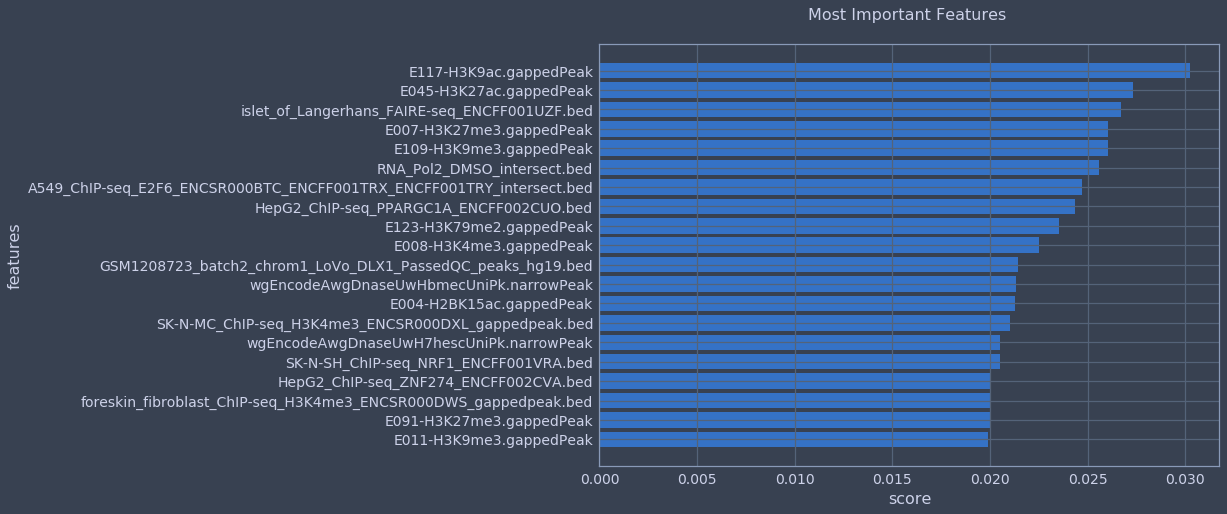

In [208]:
# Visualize scores for each feature from test
feat_importance(mic_scores, mic_features, n=len(mic_features))

In [211]:
# Save training and testing datframes only consisting of the features we have selected
chi_Xtraindf = X_train.iloc[:, chi_idx]
chi_Xtestdf = X_test.iloc[:, chi_idx]

# Write the created dataset to a file so we can test model performance later
chi_Xtraindf.to_csv("../data/T2D_data/FeatureSelected/chi2/X_train")
y_train.to_csv("../data/T2D_data/FeatureSelected/chi2/y_train")
chi_Xtestdf.to_csv("../data/T2D_data/FeatureSelected/chi2/X_test")
y_test.to_csv("../data/T2D_data/FeatureSelected/chi2/y_test")

In [213]:
# Save training and testing datframes only consisting of the features we have selected
mic_Xtraindf = X_train.iloc[:, mic_idx]
mic_Xtestdf = X_test.iloc[:, mic_idx]

# Write the created dataset to a file so we can test model performance later
mic_Xtraindf.to_csv("../data/T2D_data/FeatureSelected/mic/X_train")
y_train.to_csv("../data/T2D_data/FeatureSelected/mic/y_train")
mic_Xtestdf.to_csv("../data/T2D_data/FeatureSelected/mic/X_test")
y_test.to_csv("../data/T2D_data/FeatureSelected/mic/y_test")